# Lost Days:
The number of days a property was available, i.e. it was not rented, is not benificial for the hosts since more the number of days property was available lesser the revenue from it. As a host, one would like to rent their property every single day of the year. I explored this target variable from Calender dataset of airbnb by summing up the number of avalilable days for a given property.

In this analysis, I would like to see if there are any factors driving high number of lost days so that by avoiding these trends host can achive maximum revenue from their property.


In [8]:
# Run dataprocessing Notebook
%run dataprocessing.ipynb

# Select relavent features for analysis
selected_vars = [ 'experiences_offered',
       'transit', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'market', 
       'zipcode', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'square_feet', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'has_availability',
       'number_of_reviews',
       'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'requires_license', 
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture',
       'require_guest_phone_verification',
       'reviews_per_month','lost_days']

There are many features that are just informative in nature. To reduce the dimentianllity let us remove such columns from the data.

In [9]:
# Load csv into dataframes
listing_df= pd.read_csv('..//data//listings.csv')
# Load csv into dataframes
calender_df= pd.read_csv('..//data//calendar.csv')

# Replace t and f in 'available' coulnm by 1 and 0 repsp to count 
calender_df['available'].replace(['t','f'],[1,0],inplace=True)

# Replace NaNs in price ccolumn by 0
calender_df.fillna(value=0,inplace=True)

cal_series = calender_df.groupby(['listing_id']).available.sum()

cal_df = pd.DataFrame(cal_series).reset_index().rename(index=int,columns={'listing_id':'id','available':'lost_days'}).set_index('id')
list_df = listing_df.set_index('id')
merged_df = pd.merge(cal_df,list_df,how='left',on='id')

print("There are total : "+str( merged_df[merged_df['lost_days'] == 365].shape[0]) + " listings, that were never rented in 2016")

X,y = data_wrangling(merged_df,selected_vars,target='lost_days')

There are total : 678 listings, that were never rented in 2016
Index(['host_response_rate', 'host_acceptance_rate',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'lost_days', 'Facilities',
       'Host_experience'],
      dtype='object')
Index(['zipcode', 'property_type', 'room_type', 'bed_type',
       'cancellation_policy'],
      dtype='object')


In [10]:
# Fit the model and obtain pred response
lm_model = LinearRegression(normalize=True)
lm_model.fit(X, y)
y_preds = lm_model.predict(X)

# Append the r2 value from the test set
r2_scores= (r2_score(y, y_preds))

In [11]:
print(r2_scores)

0.11162445499966778


In [12]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X)

#A quick look at the top results
print(coef_df.head(10))

                  est_int       coefs   abs_coefs
68     property_type_Dorm -117.158724  117.158724
60      zipcode_99\n98122  107.613102  107.613102
77  room_type_Shared room   92.483755   92.483755
58          zipcode_98178   80.065968   80.065968
51          zipcode_98126   68.898874   68.898874
75     property_type_Yurt  -62.582051   62.582051
59          zipcode_98199   61.366918   61.366918
66   property_type_Chalet   61.065739   61.065739
50          zipcode_98125   58.275747   58.275747
72     property_type_Tent  -49.759832   49.759832


# Results

1. Property type 
2. Zipcode  
3. Room type
4. require_guest_profile_picture
5. Bed Type  

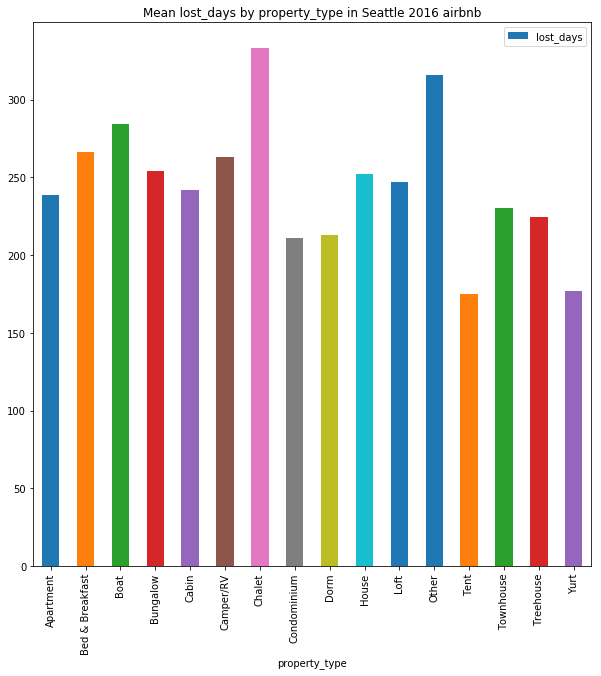

In [13]:
plot_by_target(merged_df,'property_type','lost_days')

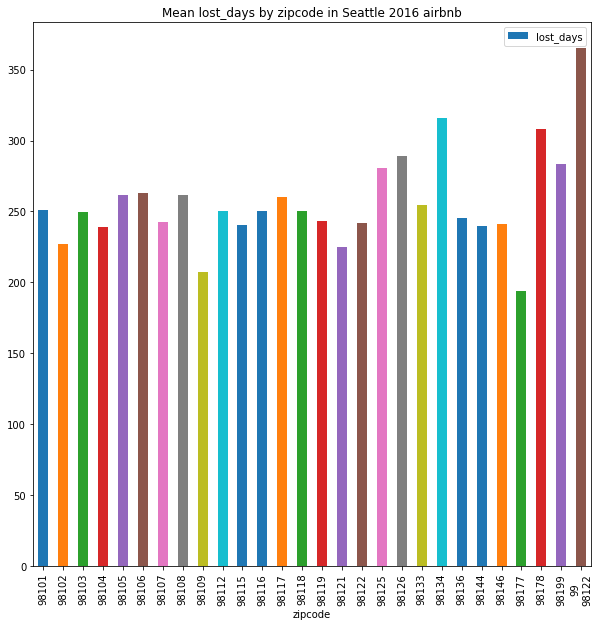

In [14]:
plot_by_target(merged_df,'zipcode','lost_days')

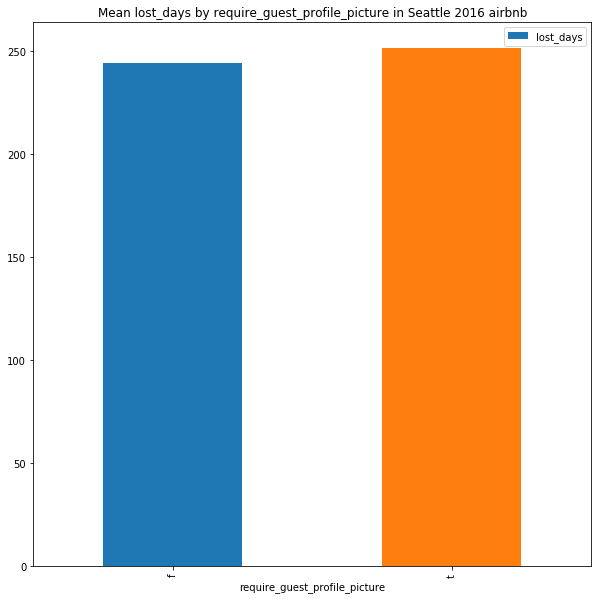

In [15]:
plot_by_target(merged_df,'require_guest_profile_picture','lost_days')